In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.stats import chi2_contingency

In [3]:
def string_to_int_list(input_string):
    """
    Converts a string representation of a list into a list of integers.

    Parameters:
    input_string (str): The string representation of a list (e.g., "[1, 2, 3]").

    Returns:
    list: A list of integers.

    Raises:
    ValueError: If the input string is not a valid list of integers.
    """
    try:
        # Safely evaluate the input string as a list
        result = eval(input_string)
        if isinstance(result, list) and all(isinstance(x, int) for x in result):
            return result
        else:
            raise ValueError("Input string does not represent a list of integers.")
    except (SyntaxError, ValueError):
        raise ValueError("Invalid input string format.")
    
def string_to_float_list(input_string):
    """
    Converts a string representation of a list into a list of floats.

    Parameters:
    input_string (str): The string representation of a list (e.g., "[0., 0.6, 3.0]").

    Returns:
    list: A list of floats.

    Raises:
    ValueError: If the input string is not a valid list of floats.
    """
    try:
        # Safely evaluate the input string as a list
        result = eval(input_string)
        if isinstance(result, list) and all(isinstance(x, float) for x in result):
            return result
        else:
            raise ValueError("Input string does not represent a list of floats.")
    except (SyntaxError, ValueError):
        raise ValueError("Invalid input string format.")
    
def fromListToFreq(l, maxVal):
    """
    Function that receives as input a list l of integers values and the max possible value and returns an array of the frequency of each integer value in the list
    """
    freq = [0] * (maxVal + 1)
    for i in l:
        freq[i] += 1
    #Add a pseudo count of 10^-7 to avoid division by zero
    freq = [f + 1e-7 for f in freq]
    #Normalize the frequency
    freq = [f/sum(freq) for f in freq]
    return freq

def loglikelihood(data, pdf):
    """
    Function that computes the loglikelihood of the data given a pdf

    Parameters:
    data (list): List of integers
    pdf (list): List of floats representing the probability density function of the integer values

    Returns:
    float: The loglikelihood of the data given the pdf
    """
    #add pseudocount to pdf and renormalize
    pdf = [p + 1e-7 for p in pdf]
    pdf = [p/sum(pdf) for p in pdf]
    return sum([np.log(pdf[d]) for d in data])

def extract_paramters_from_column(column):
    """
    Extracts the depth and epsilon parameters from the given column name.

    Parameters:
    column (str): The column name string in the format metric + "_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_negLL"

    Returns:
    tuple: A tuple containing the depth and epsilon as integers and floats respectively.
    """
    pattern = r"_depth_(\d+)_epsilon_([\d\.]+)_negLL"
    match = re.match(pattern, column)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        return depth, epsilon
    else:
        raise ValueError("Column name does not match the expected format.")

In [4]:
newSimPath = "./SIM_OUTPUT/"

In [5]:
#Import participants data
dfParticipants = pd.read_csv('./Rdf2.csv', usecols=['TrialID', 'R_BB', "N_REWARDS"])
dfParticipants['R_BB'] = dfParticipants['R_BB'].apply(string_to_int_list)

In [6]:
#Import problemList.txt
problemList = list(pd.read_csv("problemList.txt", sep="\t", header=None)[0].values)
#Remove the .json.json extension
problemList = [problem[:-10] for problem in problemList]
mapMainExp = list(pd.read_csv("mapMainExp.txt", sep="\t", header=None)[0].values)
#Find the common problems between the problemList and mapMainExp
commonProblems = list(set(problemList).intersection(mapMainExp))
#Find the indices of the common problems in the problemList
indices = [problemList.index(problem) for problem in commonProblems]
#Sort the indices as they appear in mapMainExp
indices = sorted(indices, key=lambda x: mapMainExp.index(problemList[x]))

In [7]:
dfModel = pd.DataFrame()

## epsilon-greedy with different metrics

In [8]:
def extract_parameters_from_epsilon_greedy(filename, metric = ""):
    """
    Extracts the depth and epsilon parameters from the given filename.

    Parameters:
    filename (str): The filename string in the format "PDBetweenness" + str(depth) + "Epsilon" + str(epsilon) + "BETA100.csv"

    Returns:
    tuple: A tuple containing the depth and epsilon as integers and floats respectively.
    """
    pattern = "PD"+ metric +r"(\d+)Epsilon([\d\.]+)BETA100\.csv"
    match = re.match(pattern, filename)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        return depth, epsilon
    else:
        raise ValueError("Filename does not match the expected format.")

In [9]:
metric = ""
files = os.listdir(newSimPath)
files = [f for f in files if f.startswith("PD"+metric)]
#Remove all the files that do not end with BETA100.csv
files = [f for f in files if f.endswith("BETA100.csv")]
#Remove all the files that contain Betweenness in their name
files = [f for f in files if "Betweenness" not in f]
#Remove all the files that contain Random in their name
files = [f for f in files if "Random" not in f]
#Remove all the files that contain Laplacian in their name
files = [f for f in files if "Laplacian" not in f]
#Sort the files
files = sorted(files)

In [10]:
nDoF = 2
dfConcat = pd.DataFrame()
for file in files[:]:
    #Extract the depth and epsilon parameters from the filename
    depth, epsilon = extract_parameters_from_epsilon_greedy(file, metric)
    #Read the file
    data = pd.read_csv(newSimPath + file)
    #Drop the first column
    data = data.drop(data.columns[0], axis=1)
    data[metric + "_depth_" + str(depth) + "_epsilon_" +str(epsilon)] = data.apply(lambda x: [x[col] for col in data.columns if not pd.isna(x[col])], axis=1)
    #Make a column with the problem name in problemList
    data["problem"] = problemList
    #Drop the rows that are not in the common problems
    data = data.iloc[indices]
    #Reset the index
    data = data.reset_index(drop=True)
    data = data[["problem", metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)]]
    #for each row of data compute the loglikelihood of the data given the pdf of the participants
    negllcolumn = []
    for i, row in data.iterrows():
        problem = row["problem"]
        dataProblem = row[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)]
        #Get the participants data for the problem
        participantsData = dfParticipants.loc[(dfParticipants.TrialID == problem), "R_BB"].values[0]
        #Sample size
        ndata = len(participantsData)
        #Compute the loglikelihood ofparticipantsData given the pdf of the column "Betweenness_depth_" + str(depth) + "_epsilon_" +str(epsilon)
        model = row[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)]
        negll = -loglikelihood(participantsData, model)
        negllcolumn.append(negll)

    #Add the column with the negative loglikelihood to the data
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)+"_negLL"] = negllcolumn
    #Compute the AIC and BIC
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_AIC"] = data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)+"_negLL"].apply(lambda x: np.array(x)*2 + 2*nDoF)
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BIC"] =data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)+"_negLL"].apply(lambda x: np.array(x)*2 + nDoF*np.log(ndata))

    #Concatenate the data to the previous data along the columns and avoid duplicating the problem column
    dfConcat = pd.concat([dfConcat, data], axis=1)
    #Drop the duplicated problem column
    dfConcat = dfConcat.loc[:,~dfConcat.columns.duplicated()]
    #Drop the column with the model distribution
    dfConcat = dfConcat.drop(metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon), axis=1)

#Select the columns that end with negLL
dfNegLL = dfConcat.filter(regex='_negLL$', axis=1)
#Find the minimum value of negative loglikelihood for each problem
dfConcat["minNegLL" + metric] = dfNegLL.min(axis=1)
#Find the model that has the minimum value of negative loglikelihood for each problem
dfConcat["minNegLLColumn" + metric] = dfNegLL.idxmin(axis=1)

#Select the columns that start with AIC
dfAIC = dfConcat.filter(regex='_AIC$', axis=1)
#Find the minimum value of AIC for each problem
dfConcat["minAIC" + metric] = dfAIC.min(axis=1)
#Find the model that has the minimum value of AIC for each problem
dfConcat["bestModelAIC" + metric] = dfAIC.idxmin(axis=1)

#Select the columns that start with BIC
dfBIC = dfConcat.filter(regex='_BIC$', axis=1)
#Find the minimum value of BIC for each problem
dfConcat["minBIC" + metric] = dfBIC.min(axis=1)
#Find the model that has the minimum value of BIC for each problem
dfConcat["bestModelBIC" + metric] = dfBIC.idxmin(axis=1)

dfModel = pd.concat([dfModel, dfConcat[["problem", "minNegLL" + metric, "minNegLLColumn" + metric, "minAIC" + metric, "bestModelAIC" + metric, "minBIC" + metric, "bestModelBIC" + metric]]], axis=1)
#Remove the duplicated problem column
dfModel = dfModel.loc[:,~dfModel.columns.duplicated()]

## MODEL COMPARISON

In [11]:
def extract_paramters_from_column(column, metric = ""):
    """
    Extracts the depth and epsilon parameters from the given column name.
    Parameters:
    column (str): The column name string in the format metric + "_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_negLL"

    Returns:
    tuple: A tuple containing the depth and epsilon as integers and floats respectively.
    """
    pattern = metric + r"_depth_(\d+)_epsilon_([\d\.]+)_AIC"
    match = re.match(pattern, column)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        return depth, epsilon
    else:
        raise ValueError("Column name does not match the expected format.")

In [12]:
dfModel.loc[:, "extract_parametersRandom"] = dfModel["bestModelAIC"].apply(lambda x: extract_paramters_from_column(x, metric))

In [13]:
#Extract the depth and epsilon parameters from the column extract_parameters
dfModel.loc[:, "depthRandom"] = dfModel["extract_parametersRandom"].apply(lambda x: x[0])
dfModel.loc[:, "epsilonRandom"] = dfModel["extract_parametersRandom"].apply(lambda x: x[1])

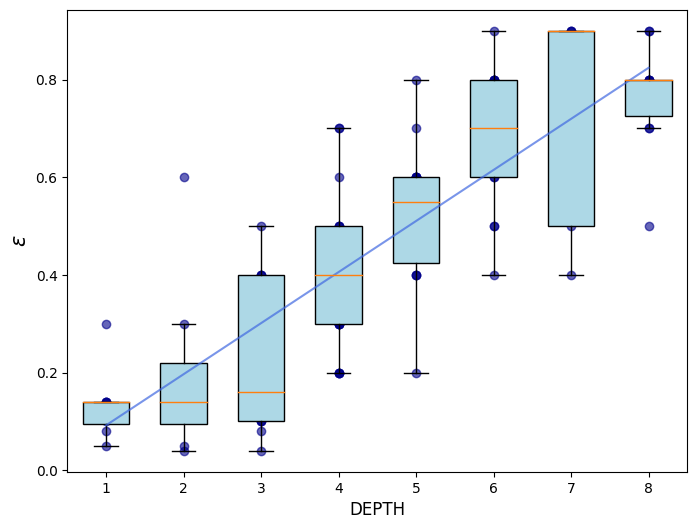

In [14]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the boxplot
boxprops = dict(facecolor="lightblue", alpha=0.7)  # Define box properties
bp = ax.boxplot(
    [dfModel[dfModel['depthRandom'] == d]['epsilonRandom'] for d in sorted(dfModel['depthRandom'].unique())],
    patch_artist=True,  # Enable box filling
    showfliers=False,
    widths=0.6
)

# Fill the boxes with color
colors = ["lightblue"] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Scatter plot
depths = dfModel["depthRandom"].values
epsilons = dfModel["epsilonRandom"].values
ax.scatter(depths, epsilons, color="darkblue", alpha=0.6)

# Linear regression
m, b = np.polyfit(dfModel["depthRandom"], dfModel["epsilonRandom"], 1)
xtemp = np.array(sorted(dfModel["depthRandom"].unique()))
ax.plot(xtemp, m * xtemp + b, color="royalblue", alpha=0.7)

# Labels and title
ax.set_xlabel("DEPTH", fontsize=12)
ax.set_ylabel("$\epsilon$", fontsize=15)
plt.title("")  # Remove the title
plt.suptitle("")  # Remove the suptitle
#plt.savefig("epsilon_vs_depthGreedy.png", bbox_inches='tight', dpi=300)
plt.show()

In [15]:
#Estimate the correlation between the depth and epsilon parameters
from scipy.stats import pearsonr
pearsonr(dfModel["depthRandom"], dfModel["epsilonRandom"])


(0.8063896307297459, 8.788675231360749e-22)

In [16]:
#Import participants data
Rdf = pd.read_csv('./Rdf2.csv')
#Rdf["MinAgentFORWARD"]

In [17]:
#Rename Rdf["TrialID"] to Rdf["problem"]
Rdf = Rdf.rename(columns={"TrialID": "problem"})
#Add Rdf["MinAgentFORWARD"] to dfModel according to the problem column
dfModel = pd.merge(dfModel, Rdf[["problem", "MinAgentFORWARD"]], on="problem")

<Figure size 2000x1500 with 0 Axes>

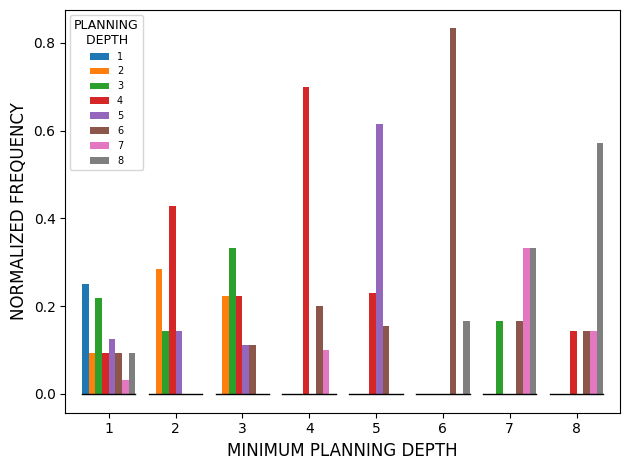

In [19]:
df_grouped = dfModel.groupby("MinAgentFORWARD").depthRandom.value_counts().unstack().fillna(0)

# Normalize the DataFrame by dividing each value by the sum of its row
df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)

plt.figure(figsize=(20, 15))
ax = df_normalized.plot(kind="bar", width=0.8, legend=True)
plt.xticks(rotation=0)
plt.ylabel("NORMALIZED FREQUENCY", fontdict={'fontsize': 12})
plt.xlabel("MINIMUM PLANNING DEPTH", fontdict={'fontsize': 12})
plt.tight_layout()

# make the legend smaller and set a title and set the legend outside the plot
plt.legend(title="PLANNING\n   DEPTH", fontsize=7, title_fontsize=9, loc='upper left')
# Add brackets above each x-tick
group_labels = df_normalized.index.tolist()
x_ticks = np.arange(len(group_labels))
bar_width = 0.8
for i, tick in enumerate(x_ticks):
    ax.plot([tick - bar_width / 2, tick + bar_width / 2], [-.001, -.001], color='black', lw=1)
    #ax.text(tick, -.15, group_labels[i], ha='center', va='bottom', fontsize=10)
#Supertitle
plt.suptitle("")
#plt.savefig("normalized_frequency_depthRandom.png", bbox_inches='tight', dpi=300)
plt.show()

In [64]:
#Find all the columns that starti with _depth_1_ and end with AIC
dfAIC = dfConcat.filter(regex='_depth_1_.*AIC$', axis=1)
#From the columns extract the values comprised between _depth_1_epsilon_ and _AIC
epsilons = dfAIC.columns.str.extract(r'_depth_1_epsilon_([\d\.]+)_AIC').values.flatten()
#Convert the epsilons to float
epsilons = epsilons.astype(float)

In [69]:
#for each row and each depth find the epsilon that minimizes the AIC
for i, row in dfConcat.iterrows():
    for depth in range(1,9):
        minAIC = np.inf
        for epsilon in epsilons:
            AIC = row["_depth_" + str(depth) + "_epsilon_" + str(epsilon) + "_AIC"]
            if AIC < minAIC:
                minAIC = AIC
                bestEpsilon = epsilon
        dfConcat.loc[i, "_depth_" + str(depth) + "minAIC"] = minAIC


In [73]:
#Rename Rdf["TrialID"] to Rdf["problem"]
Rdf = Rdf.rename(columns={"TrialID": "problem"})
#Add Rdf["MinAgentFORWARD"] to dfModel according to the problem column
dfConcat = pd.merge(dfConcat, Rdf[["problem", "MinAgentFORWARD"]], on="problem")

In [161]:
columnsTBRanked = ["_depth_" +str(depth) + "minAIC" for depth in range(1, 9)]

averageRanks = np.zeros((len(dfConcat.problem.unique()), 9))
for trialIndex, problem in enumerate(Rdf.problem.unique()[:]):
    #Get the loglikelihoods of columnNameLs
    AICS = dfConcat.loc[dfConcat.problem == problem, columnsTBRanked].values[0]
    #Add small noise to avoid ties
    AICS += np.random.normal(0, 10**-10, len(AICS))
    #Rank the AICS
    depthRanked = np.argsort(AICS) + 1
    for depth in range(1, 9):
        averageRanks[trialIndex, depth-1] = np.where(depthRanked == depth)[0][0]
    averageRanks[trialIndex, -1] = np.where(depthRanked ==  Rdf.loc[Rdf.problem == problem, "MinAgentFORWARD"].values[0])[0][0]

rank = np.transpose(averageRanks)
#Get the frequency of each occurence of each rank
rankFreq = np.zeros((9, 8))
for modelIndex in range(9):
    for rankIndex in range(8):
        rankFreq[modelIndex, rankIndex] = np.sum(rank[modelIndex] == rankIndex)
#get the p-values of chi2 indipendence test of rankFreq[0] and rankFreq[-1]
for depth in range(0, 8):
    chi2, p, _, _ = chi2_contingency(rankFreq[[depth, -1]])
    print("D =", depth, p, chi2)

D = 0 4.278111459600716e-08 47.591969469174245
D = 1 1.4101004587313691e-06 39.742316816073625
D = 2 7.901551238509928e-05 30.43468030690537
D = 3 0.005880157716642764 19.85999747658409
D = 4 1.5607641845086494e-05 34.228669576037994
D = 5 0.048584568509473014 14.14954601626108
D = 6 0.08252146721531385 12.598318041963743
D = 7 0.6865969953554123 4.781587301587301


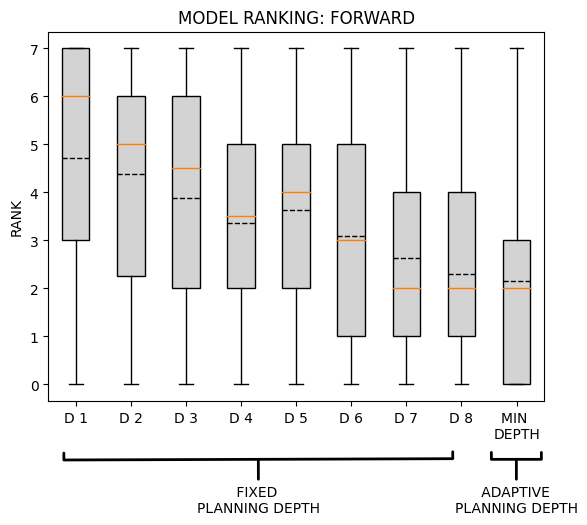

In [162]:
#Make a boxplot of average ranks showing the distribution of the ranks
fig, ax = plt.subplots()
ax.boxplot(averageRanks, showfliers = False, patch_artist = True, showmeans=True, meanline=True, meanprops = dict(color = "black"), boxprops=dict(facecolor="lightgrey"))
#For eahc boxplot scatter the points    
#for i, depth in enumerate(range(1, 10)):
#   ax.scatter(np.random.normal(i+1, 0.1, len(averageRanks[:,i])), averageRanks[:,i], alpha = 0.01, c = "k")
ax.set_xticks(range(1, 10), ["D " + str(depth) for depth in range(1, 9)]  + ["MIN \nDEPTH"])
ax.set_ylabel("RANK")
ax.set_title("MODEL RANKING: FORWARD")
#Annotate 
#ax.text(3, -2, "FIXED\nPLANNING DEPTH", fontsize = 10)
#ax.text(8, -2.7, "      ADAPTIVE\nPLANNING DEPTH", fontsize = 10)
ax.annotate('         FIXED\nPLANNING DEPTH', xy=(0.4237, -0.15), xytext=(0.3, -0.3), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=14.0, lengthB=0.5', lw=2.0, color='k'))
ax.annotate('      ADAPTIVE\nPLANNING DEPTH', xy=(0.944, -0.15), xytext=(0.82, -0.3), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=1.8, lengthB=0.5', lw=2.0, color='k'))
#save the figure
plt.savefig("./RankTestEpsilonGreedy.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [163]:
rank = np.transpose(averageRanks)
#Get the frequency of each occurence of each rank
rankFreq = np.zeros((9, 8))
for modelIndex in range(9):
    for rankIndex in range(8):
        rankFreq[modelIndex, rankIndex] = np.sum(rank[modelIndex] == rankIndex)
#get the p-values of chi2 indipendence test of rankFreq[0] and rankFreq[-1]
for depth in range(0, 8):
    chi2, p, _, _ = chi2_contingency(rankFreq[[depth, -1]])
    print("D =", depth+1, p, chi2)

D = 1 4.278111459600716e-08 47.591969469174245
D = 2 1.4101004587313691e-06 39.742316816073625
D = 3 7.901551238509928e-05 30.43468030690537
D = 4 0.005880157716642764 19.85999747658409
D = 5 1.5607641845086494e-05 34.228669576037994
D = 6 0.048584568509473014 14.14954601626108
D = 7 0.08252146721531385 12.598318041963743
D = 8 0.6865969953554123 4.781587301587301


In [20]:
dfModel

,problem,minNegLL,minNegLLColumn,minAIC,bestModelAIC,minBIC,bestModelBIC,extract_parametersRandom,depthRandom,epsilonRandom,MinAgentFORWARD
0,X5Y51101011110011110111100111110101111100111S2...,32.997083,_depth_4_epsilon_0.2_negLL,69.994166,_depth_4_epsilon_0.2_AIC,74.280436,_depth_4_epsilon_0.2_BIC,"(4, 0.2)",4,0.20,4
1,X5Y51110110111110010110011111011100110111011S4...,40.414820,_depth_4_epsilon_0.2_negLL,84.829640,_depth_4_epsilon_0.2_AIC,89.115909,_depth_4_epsilon_0.2_BIC,"(4, 0.2)",4,0.20,4
2,X5Y51111110111111111111111001111011101111101S1...,28.228271,_depth_3_epsilon_0.1_negLL,60.456543,_depth_3_epsilon_0.1_AIC,64.742812,_depth_3_epsilon_0.1_BIC,"(3, 0.1)",3,0.10,3
3,X5Y50111111111011111010111111001010111111011S7...,66.814684,_depth_5_epsilon_0.5_negLL,137.629368,_depth_5_epsilon_0.5_AIC,141.915638,_depth_5_epsilon_0.5_BIC,"(5, 0.5)",5,0.50,1
4,X5Y51111111101001111110101100110011110011111S8...,98.650115,_depth_5_epsilon_0.7_negLL,201.300230,_depth_5_epsilon_0.7_AIC,205.586499,_depth_5_epsilon_0.7_BIC,"(5, 0.7)",5,0.70,1
...,...,...,...,...,...,...,...,...,...,...,...
85,X6Y8100111101100111111111001111001111111111111...,125.744348,_depth_2_epsilon_0.3_negLL,255.488696,_depth_2_epsilon_0.3_AIC,259.774965,_depth_2_epsilon_0.3_BIC,"(2, 0.3)",2,0.30,1
86,X6Y8111110111110110111110101100101111111110101...,118.299979,_depth_4_epsilon_0.4_negLL,240.599958,_depth_4_epsilon_0.4_AIC,244.886227,_depth_4_epsilon_0.4_BIC,"(4, 0.4)",4,0.40,4
87,X6Y8101111111110100110111100111111100001111111...,144.730677,_depth_8_epsilon_0.8_negLL,293.461354,_depth_8_epsilon_0.8_AIC,297.747624,_depth_8_epsilon_0.8_BIC,"(8, 0.8)",8,0.80,7
88,X6Y8110101110011111111110111110010110111001110...,103.286875,_depth_8_epsilon_0.9_negLL,210.573749,_depth_8_epsilon_0.9_AIC,214.860019,_depth_8_epsilon_0.9_BIC,"(8, 0.9)",8,0.90,8


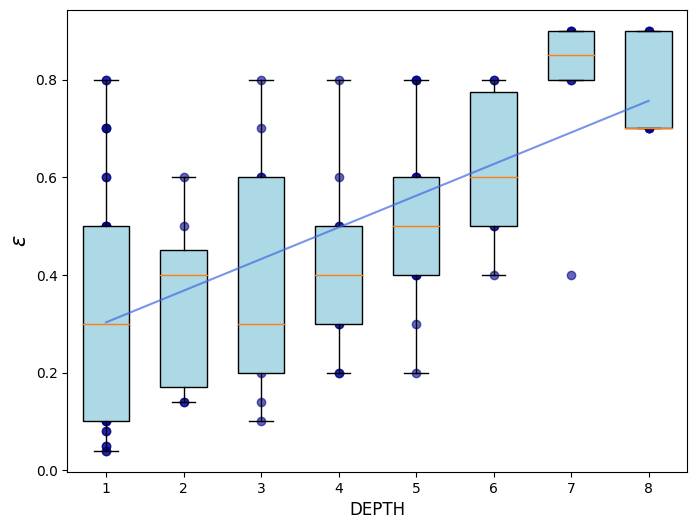

In [23]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the boxplot
boxprops = dict(facecolor="lightblue", alpha=0.7)  # Define box properties
bp = ax.boxplot(
    [dfModel[dfModel['MinAgentFORWARD'] == d]['epsilonRandom'] for d in sorted(dfModel['MinAgentFORWARD'].unique())],
    patch_artist=True,  # Enable box filling
    showfliers=False,
    widths=0.6
)

# Fill the boxes with color
colors = ["lightblue"] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Scatter plot
depths = dfModel["MinAgentFORWARD"].values
epsilons = dfModel["epsilonRandom"].values
ax.scatter(depths, epsilons, color="darkblue", alpha=0.6)

# Linear regression
m, b = np.polyfit(dfModel["MinAgentFORWARD"], dfModel["epsilonRandom"], 1)
xtemp = np.array(sorted(dfModel["MinAgentFORWARD"].unique()))
ax.plot(xtemp, m * xtemp + b, color="royalblue", alpha=0.7)

# Labels and title
ax.set_xlabel("DEPTH", fontsize=12)
ax.set_ylabel("$\epsilon$", fontsize=15)
plt.title("")  # Remove the title
plt.suptitle("")  # Remove the suptitle
plt.savefig("epsilon_vs_depthOriginal.png", bbox_inches='tight', dpi=300)
plt.show()

In [22]:
# Estimate the correlation between the depth and epsilon parameters
from scipy.stats import pearsonr
pearsonr(dfModel["MinAgentFORWARD"], dfModel["epsilonRandom"])

(0.5866375811660929, 1.2328646972290186e-09)